In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
tickers = ['MRK', 'SQ', 'ES', 'GOOG', 'AMZN', 'GM', 'MBLY']

finwiz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

In [3]:
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url, headers={'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [4]:
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])
        
analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

today_date = pd.to_datetime('today').date()  
news['Date'] = news['Date'].replace('Today', today_date)

news['Date'] = pd.to_datetime(news['Date'])

In [ ]:
filtered_news = news[(news['Ticker'] == 'MBLY') & ((news['compound'] < -0.2) | (news['compound'] > 0.2)) & (news['Date'] == pd.to_datetime('2023-11-25'))]

filtered_headlines = filtered_news[['Date', 'Time', 'Headline', 'compound']]
filtered_headlines

In [ ]:
filtered_news = news[(news['Ticker'] == 'GM')]

filtered_headlines = filtered_news[['Date', 'Time', 'Headline', 'compound']]
filtered_headlines

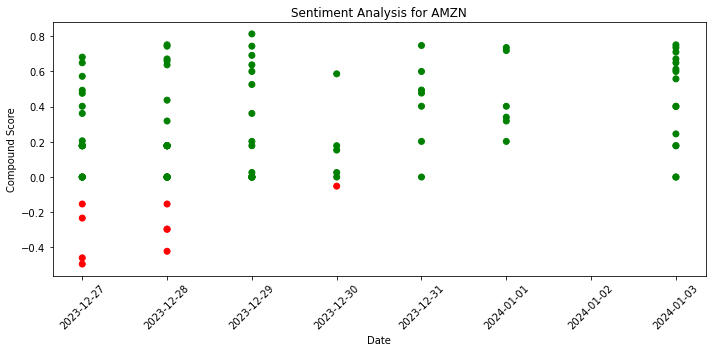

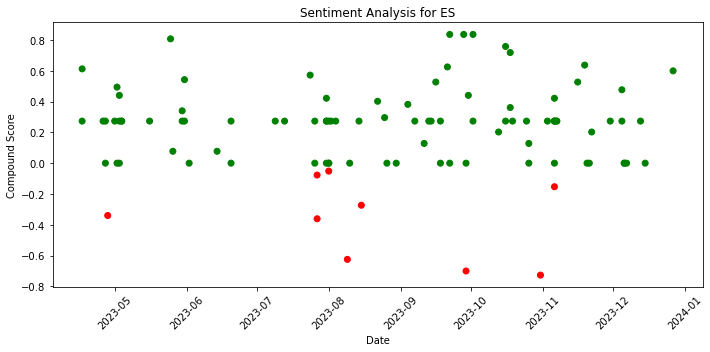

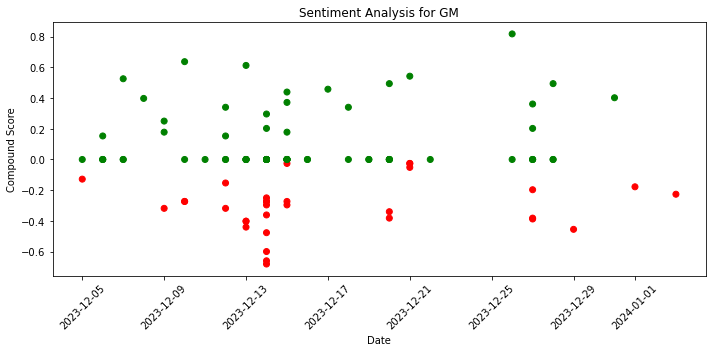

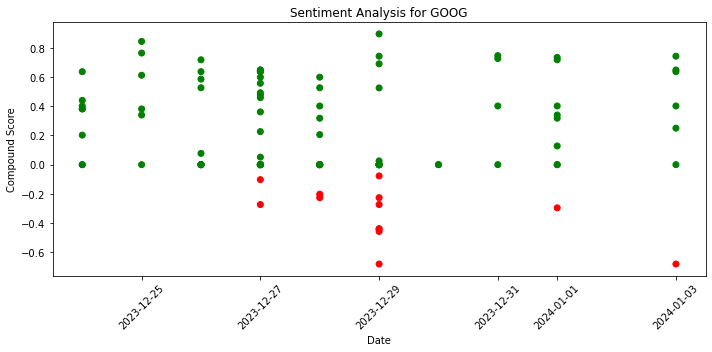

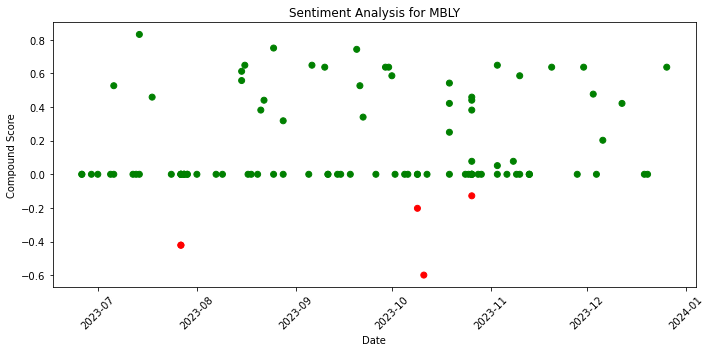

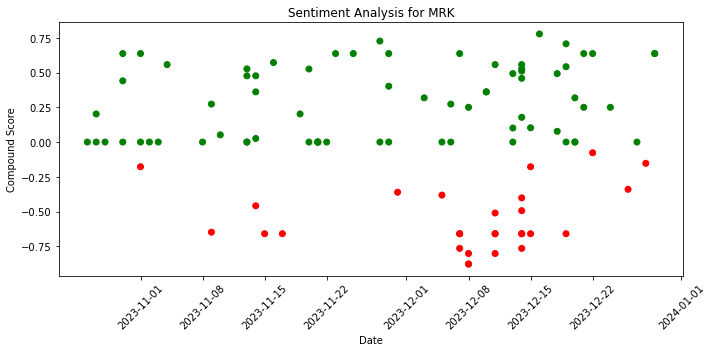

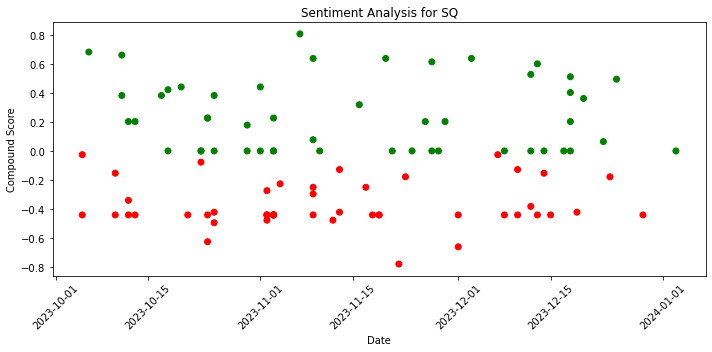

In [5]:
grouped = news.groupby('Ticker')

for ticker, group in grouped:
    plt.figure(figsize=(10, 5))
    
    current_ticker_data = group[group['Ticker'] == ticker]
    
    colors = ['red' if c < 0 else 'green' for c in current_ticker_data['compound']]
    
    plt.scatter(current_ticker_data['Date'], current_ticker_data['compound'], color=colors)
    plt.title(f'Sentiment Analysis for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Compound Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
df

,Mean Sentiment
Ticker,
AMZN,0.26
ES,0.22
GOOG,0.21
MBLY,0.15
MRK,0.05
GM,-0.01
SQ,-0.07
